In [2]:
import MulensModel as mm
import matplotlib.pyplot as plt
import numpy as np
from param_utils import Param, Params

In [3]:
def get_curve(args):
    my_1S2L_model = mm.Model({'t_0': 0, 'u_0': args[0],
                              't_E': args[1], 'rho': args[2], 'q': args[3], 's': args[4],
                              'alpha': args[5]})
    times = my_1S2L_model.set_times()
    times -= min(times)
    lc = my_1S2L_model.get_lc(source_flux=1)
    return times, lc

In [4]:
u_0 = Param("u_0", 0, np.sqrt(1), 0.5)
print(u_0)
print(u_0.get_sample_n(0, 1, 1))

(array([0.9861207]), array(['u_0: 0.99'], dtype='<U9'))


/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/model.py:267: UserWarning: No blend_flux not specified. Assuming blend_flux = zero.
  warnings.warn(
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)


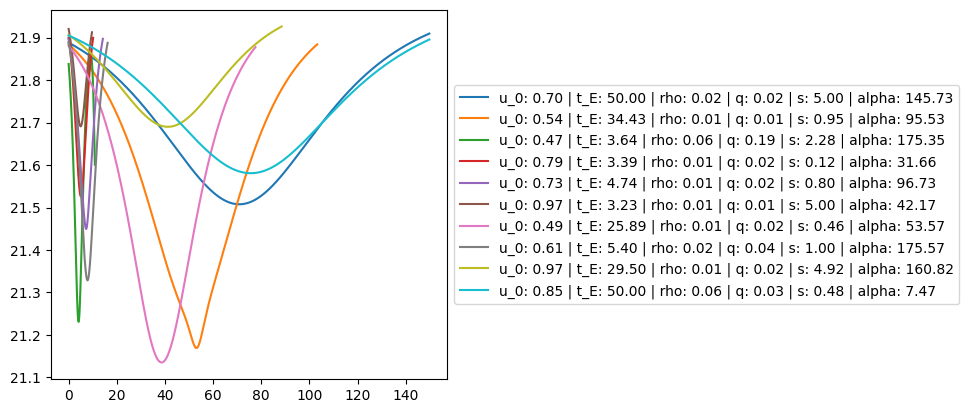

In [5]:
fig = plt.figure()
ax = plt.subplot(111)
for i in range(10):
    params = Params()
    args, labels = params.get_val()
    x, y = get_curve(args)
    ax.plot(x, y, label=' | '.join(labels))
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/tmp/ipykernel_102161/2124316833.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 640x480 with 0 Axes>

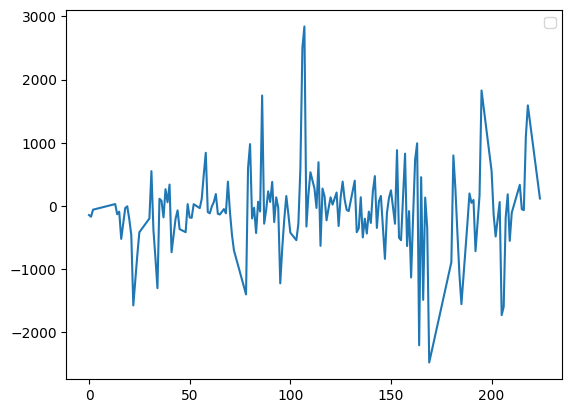

In [22]:
# add random light curve section to star as noise
from tqdm import tqdm
from astropy.io import ascii
import os

fig = plt.figure()
def choose_random_noise_curve(chunk_size=225, outlier_cutoff=3):
    fdir = "data/lightcurves/"
    directory = os.fsencode(fdir)
    files = os.listdir(directory)

    def grab_curve():
        # choose a random light curve
        selection_index = np.random.choice(len(files), replace=False) 
        curve = ascii.read(fdir + os.fsdecode(files[selection_index]), format='ipac')
        
        # grab all real values
        unmasked_inds = curve['cor_flux'].data.nonzero()

        # check there are real values
        if len(unmasked_inds[0]) == 0:
            return grab_curve()
    
        # first real index
        start = unmasked_inds[0][0]
        
        # fill x range to interpolate over
        x_filled = np.arange(curve['HJD'][start], curve['HJD'][start] + chunk_size)

        # grab real data + interpolate + return
        unmasked = curve['cor_flux'].data[unmasked_inds]
        unmasked_time = curve['HJD'][unmasked_inds]
        sample_interpolated = np.interp(x_filled, unmasked_time, unmasked)

        x_filled = x_filled - curve['HJD'][start]
        return x_filled, sample_interpolated

    x_i, y_i = grab_curve()

    # we check for variance with a moving average (faster than FFT methods)
    def moving_average(a, n=20):
        # n = 10 to capture large events (microlensing events) without filtering out noise
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    moving_avg = moving_average(y_i)
    curve_variance = max(moving_avg)
    max_variance = outlier_cutoff * np.std(y_i)
    
    if curve_variance > max_variance:
        #print("outliers in our noise curve, grabbing new data")
        x_i, y_i = grab_curve()

    return x_i, y_i

x, curve = choose_random_noise_curve()

fig = plt.figure()
plt.plot(x, curve)
plt.legend()
plt.show()

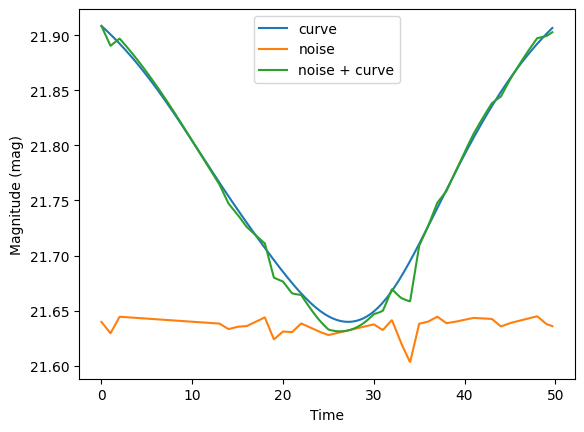

In [23]:
params = Params()
args, labels = params.get_val()
x, y = get_curve(args)
noise_x, noise_y = choose_random_noise_curve()

fig = plt.figure()
plt.plot(x, y, label="curve")
noise_interp = np.interp(x, noise_x, noise_y)
noise_small = noise_interp * np.std(y) / (max(noise_y) - min(noise_y))
plt.plot(x, noise_small + min(y), label="noise")
plt.plot(x, y + noise_small, label="noise + curve")
plt.xlabel("Time")
plt.ylabel("Magnitude (mag)")
plt.legend()
plt.show()

In [51]:
def noisy_curve(args):
    x, y = get_curve(args)
    noise_x, noise_y = choose_random_noise_curve()
    noise_interp = np.interp(x, noise_x, noise_y)
    noise_small = noise_interp * 2 * np.std(y) / (max(noise_y) - min(noise_y))
    curve = y + noise_small

    return x, curve


In [52]:
params = Params()
labels, args = params.get_vals(10)
print("args:",','.join(['%.5f' % num for arg in args for num in arg]))

args: 0.80719,0.39953,0.54097,0.29362,0.79385,0.45382,0.63631,0.47093,0.21451,0.87008,3.78366,7.46558,30.05155,28.09651,50.00000,50.00000,25.30366,50.00000,13.28190,5.84648,0.05823,0.02107,0.01549,0.01376,0.09219,0.02769,0.01461,0.01014,0.00900,0.00900,0.02466,0.00695,0.04226,0.02988,0.05635,0.01951,0.05985,0.02643,0.00297,0.01540,0.18842,0.18883,5.00000,0.53153,0.23467,0.62284,0.21939,1.76193,0.14570,3.26829,107.64414,127.98704,101.98109,163.37894,33.49030,49.18552,58.20314,101.90722,105.37459,86.75519


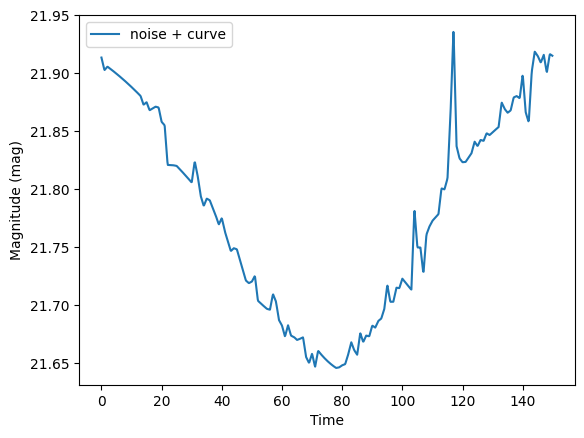

In [62]:
x, y_curve = noisy_curve(params.get_val()[0])
plt.plot(x, y_curve, label="noise + curve")
plt.xlabel("Time")
plt.ylabel("Magnitude (mag)")
plt.legend()
plt.show()

In [ ]:
arg_file = 'data/generated_lightcurves/params.csv'
f = open(arg_file, "w+")
f.close()

labels, args = params.get_vals(1000)
print(args[0])
for index in tqdm(range(1000)):
    x, y = noisy_curve(args[index])

    with open(f'data/generated_lightcurves/x/x_{index}.npy', 'wb') as f:
        np.save(f, x)

    with open(f'data/generated_lightcurves/y/y_{index}.npy', 'wb') as f:
        np.save(f, y)

    with open(arg_file, 'w') as f:
        f.write(','.join(['%.5f' % num for num in args[index]]) + '\n')
    

[0.93151425 0.936349   0.55820226 0.35960596 0.89195472 0.58732378]


100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s]


  1%|          | 9/1000 [00:00<00:02, 383.29it/s]


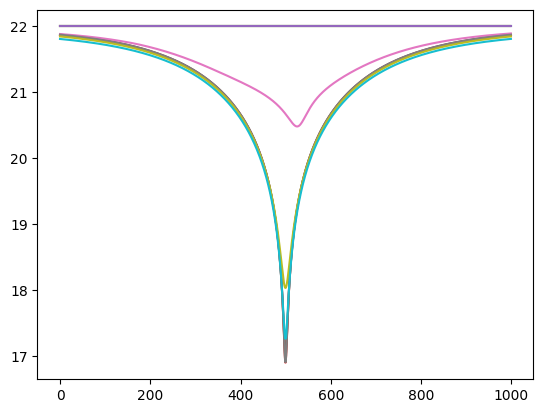

In [15]:
fdir = "data/generated_lightcurves/y/"
directory = os.fsencode(fdir)

curves = []

i = 0
for file in tqdm(os.listdir(directory)):
    filename = os.fsdecode(file)
    curve = np.load(fdir + filename) 
    plt.plot(np.arange(0, len(curve)), curve)
    i+=1
    if i == 10:
        break